# Autores: 
**Gabriel Roberto (221020870) e Jean Soares (241033810)**

# Noções de IA 2/24 - Trabalho 2
## Rede Convolucional e Transfer Learning
### 1. Introdução e Base de Dados
Neste trabalho usaremos uma rede convolucional pré-treinada e a aplicaremos em um problema novo. Também experimentaremos com a divisão da base em treinamento, validação e teste, e usaremos validação para o "early stopping" na tentativa de controlar o sobre-ajuste.

A base de dados é a "TensorFlow Flowers Dataset". Ela contém 3670 imagens coloridas de flores pertencentes a uma de  5 classes: Margarida, Dente-de-leão, Rosa, Girassol e Tulipa. [Esta página descritiva](https://www.tensorflow.org/datasets/catalog/tf_flowers) contém alguns exemplos.

Ela pode ser baixada com o código abaixo.

Obs: o módulo tensorflow_datasets a princípio não é acessível em instalações Windows. Você pode usar uma instalação local Unix, ou um serviço de núvem como o Google Colab ou Amazon Web Services.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[70%:]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)
print (train_ds.shape)
print (test_ds.shape)

2024-12-22 22:29:31.119123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/coffee/miniconda3/envs/VGG/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-22 22:29:37.018435: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(2569, 150, 150, 3)
(1101, 150, 150, 3)


Observe como foi feita a separação em 70% de dados para treinamento e 30% de dados para teste. Observe também que a base de dados original tem apenas um conjunto "train". A separação em treinamento, teste e validação é feita pelo usuário. Por isso a instrução para obter 70% do conjunto "train" e 30% do conjunto "train", o que soa estranho a princípio.

### 2. Treinando um MLP

Use esta base de dados para treinar um MLP, como feito no trabalho anterior com a base MNIST.

Escolha um MLP com 2 camadas escondidas. Não perca muito tempo variando a arquitetura porque este problema é difícil sem o uso de convoluções e o resultado não será totalmente satisfatório.

Você pode usar este código como base para definição da rede:

In [3]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(1024, activation='relu')
dense_layer_2 = layers.Dense(512, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

Observe que as imagens são achatadas (transformadas em vetor). Substitua as interrogações pelo tamanho desejado das camadas escondidas.

Neste problema vamos verificar o fenômeno do "over-fitting", e vamos tentar equilibrá-lo pela técnica de parada prematura de treinamento. Assim, dos dados de treinamento precisamos fazer uma nova separação para validação. Quando a acurácia de validação não sobe num dado número de épocas (o parâmetro "patience"), o treinamento é interrompido. Este trecho de código pode ser útil:


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 61s 896ms/step - loss: 1023.7133 - accuracy: 0.2730 - val_loss: 146.1892 - val_accuracy: 0.3794
Epoch 2/50
65/65 [==============================] - 46s 700ms/step - loss: 81.0352 - accuracy: 0.3844 - val_loss: 78.9539 - val_accuracy: 0.3210
Epoch 3/50
65/65 [==============================] - 43s 664ms/step - loss: 46.5588 - accuracy: 0.4024 - val_loss: 37.8082 - val_accuracy: 0.3988
Epoch 4/50
65/65 [==============================] - 58s 897ms/step - loss: 27.8263 - accuracy: 0.4375 - val_loss: 27.8097 - val_accuracy: 0.3113
Epoch 5/50
65/65 [==============================] - 48s 735ms/step - loss: 17.9389 - accuracy: 0.4725 - val_loss: 14.9809 - val_accuracy: 0.4377
Epoch 6/50
65/65 [==============================] - 54s 836ms/step - loss: 10.6051 - accuracy: 0.4959 - val_loss: 13.5388 - val_accuracy: 0.3969
Epoch 7/50
65/65 [==============================] - 52s 801ms/step - loss: 6.5802 - accuracy: 0.5513 - val_loss: 13.9079 - val_

Os parâmetros dados são sugestões.
Você agora pode testar o seu modelo, por exemplo, com:

In [5]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

35/35 [==============================] - 4s 120ms/step - loss: 166.1436 - accuracy: 0.3451
Accuracy: 0.3451407849788666


Mais uma vez, procure realizar ajustes, mas não espere um bom desempenho. Como dissemos, é um problema complexo de classificação de imagem, e é difícil fazer o MLP funcionar sozinho. Precisamos de um pré-processamento com base em uma rede convolucional.

### 3. Uso da rede VGG16 pré-treinada.

Lembre-se que a rede VGG usa como bloco básico uma cascata de convoluções com filtros 3x3, com "padding" para que a imagem não seja diminuída, seguida de um "max pooling" reduzindo imagens pela metade. O número de mapas vai aumentando e seu tamanho vai diminuindo ao longo de suas 16 camadas. Este é um modelo gigantesco e o treinamento com recursos computacionais modestos levaria dias ou semanas, se é que fosse possível.

No entanto, vamos aproveitar uma característica central das grandes redes convolucionais. Elas podem ser usadas como pré-processamento fixo das imagens, mesmo em um novo problema. (Lembre-se, a rede VGG original foi treinada na base ImageNet, que tem muitas categorias de imagem, não apenas flores).

O código abaixo realiza o download do modelo treinado, especifica que não será usada a última camada, e que os parâmetros do modelo-base não são ajustáveis.

Observe que a classe também tem o método preprocess_input para garantir que os dados sejam processados de maneira semelhante ao treinamento original da VGG16.

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

Você pode checar a arquitetura do modelo-base com o método "summary". Observe que há incríveis 14 milhões de parâmetros no modelo, que felizmente não vamos precisar adaptar.

In [6]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Agora, monte a rede final de forma semelhante ao MLP acima. Use o base_model como primeira camada, seguida de uma camada "flatten" (o MLP espera um vetor de entradas), e duas camadas densas. Elas não precisam ser muito grandes. Experimente com 50 e 20, respectivamente, ou algo próximo.

Volte a treinar e testar o modelo. Mesmo sem efetivamente treinar a rede VGG, ainda temos que passar os dados por ela a cada passo, e o treinamento é um tanto lento. Mas desta vez o problema deve ser resolvido satisfatoriamente.

### 4. Extras (opcionais)

4.1. Procure usar outra(s) redes convolucionais como base.

4.2. No lugar de "early stopping", experimente com regularização L1 e L2, e "dropout".

4.3. Procure (ou produza) imagens de algumas flores destas categorias, e teste em seu modelo.



In [7]:

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 294s 5s/step - loss: 2.0323 - accuracy: 0.4482 - val_loss: 1.2002 - val_accuracy: 0.5233
Epoch 2/50
65/65 [==============================] - 265s 4s/step - loss: 0.9640 - accuracy: 0.6443 - val_loss: 1.0596 - val_accuracy: 0.6012
Epoch 3/50
65/65 [==============================] - 261s 4s/step - loss: 0.7260 - accuracy: 0.7255 - val_loss: 1.0415 - val_accuracy: 0.6673
Epoch 4/50
65/65 [==============================] - 228s 4s/step - loss: 0.5960 - accuracy: 0.7591 - val_loss: 1.0871 - val_accuracy: 0.6537
Epoch 5/50
65/65 [==============================] - 276s 4s/step - loss: 0.4224 - accuracy: 0.8248 - val_loss: 1.0499 - val_accuracy: 0.6809
Epoch 6/50
65/65 [==============================] - 294s 5s/step - loss: 0.3620 - accuracy: 0.8530 - val_loss: 0.9748 - val_accuracy: 0.6907
Epoch 7/50
65/65 [==============================] - 309s 5s/step - loss: 0.2809 - accuracy: 0.8905 - val_loss: 1.1302 - val_accuracy: 0.7160
Epoch 8/50
65

In [8]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

35/35 [==============================] - 151s 4s/step - loss: 2.1459 - accuracy: 0.6621
Accuracy: 0.6621253490447998


## Item 4.1

### VGG19

In [40]:
from tensorflow.keras.applications.vgg19 import VGG19

## Loading VGG16 model
base_model_41_vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model_41_vgg19.trainable = False ## Not

## Preprocessing input
train_ds_41_vgg19 = preprocess_input(train_ds)
test_ds_41_vgg19 = preprocess_input(test_ds)

base_model_41_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [45]:
model_41_vgg19 = models.Sequential([
    base_model_41_vgg19,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_41_vgg19.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_41_vgg19.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 305s 5s/step - loss: 1.1286 - accuracy: 0.5961 - val_loss: 1.1963 - val_accuracy: 0.5623
Epoch 2/50
65/65 [==============================] - 367s 6s/step - loss: 0.7875 - accuracy: 0.6793 - val_loss: 1.2279 - val_accuracy: 0.6459
Epoch 3/50
65/65 [==============================] - 311s 5s/step - loss: 0.6449 - accuracy: 0.7377 - val_loss: 1.2064 - val_accuracy: 0.6284
Epoch 4/50
65/65 [==============================] - 315s 5s/step - loss: 0.5161 - accuracy: 0.7771 - val_loss: 1.2218 - val_accuracy: 0.6498
Epoch 5/50
65/65 [==============================] - 377s 6s/step - loss: 0.4526 - accuracy: 0.8170 - val_loss: 1.2837 - val_accuracy: 0.6498
Epoch 6/50
65/65 [==============================] - 298s 5s/step - loss: 0.3748 - accuracy: 0.8482 - val_loss: 1.3996 - val_accuracy: 0.6537
Epoch 7/50
65/65 [==============================] - 261s 4s/step - loss: 0.3248 - accuracy: 0.8637 - val_loss: 1.5174 - val_accuracy: 0.6518
Epoch 8/50
65

In [46]:
# Evaluate the model on the test dataset
loss_41_vgg19, accuracy_41_vgg19 = model_41_vgg19.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy_41_vgg19)

35/35 [==============================] - 101s 3s/step - loss: 2.9957 - accuracy: 0.6113
Accuracy: 0.6112625002861023


## Item 4.2

### Dropout

In [35]:
from tensorflow.keras.layers import Dropout

model42 = models.Sequential([
    base_model,
    flatten_layer,
    Dropout(0.2),
    dense_layer_1,
    Dropout(0.2),
    dense_layer_2,
    Dropout(0.2),
    prediction_layer
])

model42.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model42.fit(train_ds, train_labels, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
65/65 [==============================] - 209s 3s/step - loss: 0.9116 - accuracy: 0.6779 - val_loss: 1.3287 - val_accuracy: 0.6012
Epoch 2/15
65/65 [==============================] - 205s 3s/step - loss: 0.9537 - accuracy: 0.6662 - val_loss: 1.4791 - val_accuracy: 0.5759
Epoch 3/15
65/65 [==============================] - 214s 3s/step - loss: 0.7971 - accuracy: 0.7027 - val_loss: 1.6480 - val_accuracy: 0.6206
Epoch 4/15
65/65 [==============================] - 335s 5s/step - loss: 0.8487 - accuracy: 0.6920 - val_loss: 1.2882 - val_accuracy: 0.6381
Epoch 5/15
65/65 [==============================] - 353s 5s/step - loss: 0.7406 - accuracy: 0.7270 - val_loss: 1.4705 - val_accuracy: 0.6265
Epoch 6/15
65/65 [==============================] - 341s 5s/step - loss: 0.7060 - accuracy: 0.7377 - val_loss: 1.3749 - val_accuracy: 0.6440
Epoch 7/15
65/65 [==============================] - 258s 4s/step - loss: 0.7308 - accuracy: 0.7231 - val_loss: 1.4457 - val_accuracy: 0.6556
Epoch 8/15
65

In [36]:
# Evaluate the model on the test dataset
loss_42_drop, accuracy_42_drop = model42.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy_42_drop)

35/35 [==============================] - 95s 3s/step - loss: 2.2183 - accuracy: 0.6549
Accuracy: 0.6548592448234558


### L1 e L2

In [32]:

dense_layer_1_L1L2 = layers.Dense(50, activation='relu', kernel_regularizer='l1_l2')
dense_layer_2_L1L2 = layers.Dense(20, activation='relu', kernel_regularizer='l1_l2')

model_L1L2 = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1_L1L2,
    dense_layer_2_L1L2,
    prediction_layer
])

model_L1L2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_L1L2.fit(train_ds, train_labels, epochs=15, validation_split=0.2, batch_size=32)

Epoch 1/15
65/65 [==============================] - 226s 3s/step - loss: 22.3862 - accuracy: 0.4720 - val_loss: 9.6135 - val_accuracy: 0.5837
Epoch 2/15
65/65 [==============================] - 223s 3s/step - loss: 6.7768 - accuracy: 0.6725 - val_loss: 5.3639 - val_accuracy: 0.6167
Epoch 3/15
65/65 [==============================] - 250s 4s/step - loss: 4.5000 - accuracy: 0.7109 - val_loss: 4.2519 - val_accuracy: 0.6265
Epoch 4/15
65/65 [==============================] - 189s 3s/step - loss: 3.6016 - accuracy: 0.7246 - val_loss: 3.7660 - val_accuracy: 0.5837
Epoch 5/15
65/65 [==============================] - 184s 3s/step - loss: 3.3336 - accuracy: 0.7168 - val_loss: 3.4451 - val_accuracy: 0.6109
Epoch 6/15
65/65 [==============================] - 186s 3s/step - loss: 2.9325 - accuracy: 0.7397 - val_loss: 2.9951 - val_accuracy: 0.6148
Epoch 7/15
65/65 [==============================] - 184s 3s/step - loss: 2.7346 - accuracy: 0.7489 - val_loss: 3.0743 - val_accuracy: 0.6206
Epoch 8/15
6

In [33]:
# Evaluate the model on the test dataset
loss_42_L1L12, accuracy_42_L1L12 = model_L1L2.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy_42_L1L12)

35/35 [==============================] - 100s 3s/step - loss: 2.5088 - accuracy: 0.5804
Accuracy: 0.580381453037262


## Item 4.3

1/1 [==============================] - 1s 923ms/step


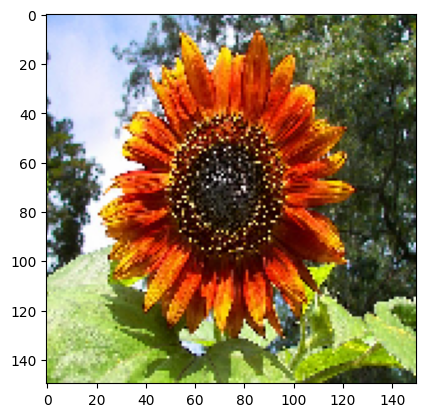

This image most likely belongs to daisy with a 35.05 percent confidence.
Real: sunflowers
1/1 [==============================] - 1s 814ms/step


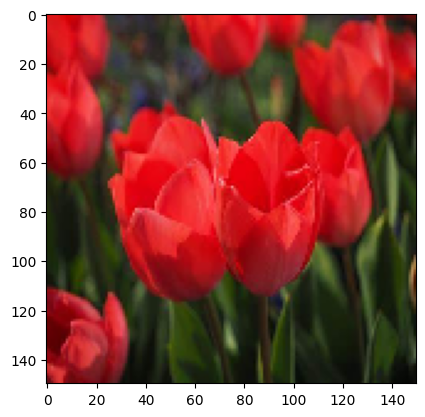

This image most likely belongs to tulips with a 40.46 percent confidence.
Real: tulips
1/1 [==============================] - 1s 893ms/step


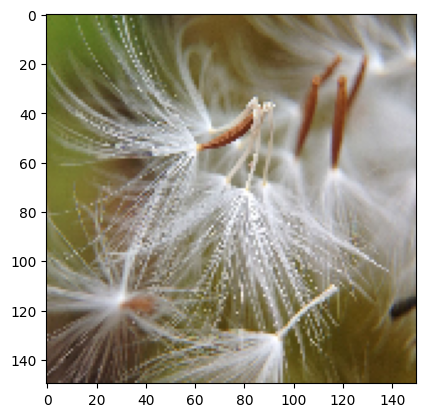

This image most likely belongs to daisy with a 35.68 percent confidence.
Real: dandelion
1/1 [==============================] - 1s 796ms/step


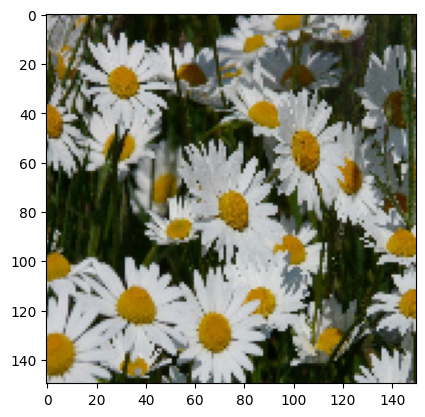

This image most likely belongs to daisy with a 40.10 percent confidence.
Real: daisy
1/1 [==============================] - 1s 786ms/step


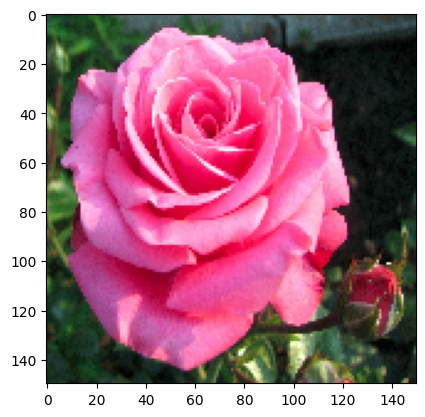

This image most likely belongs to roses with a 40.46 percent confidence.
Real: roses


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def text_labels(indice):
    labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
    return labels[int(indice)]

urls_imagens_teste = [
    "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg",
    "https://th.bing.com/th/id/OIP.NqainmbKbnBKtyo2Iv-xmwHaFj?rs=1&pid=ImgDetMain",
    "https://i.pinimg.com/originals/8a/e7/cb/8ae7cb19acd814a0e73de5e329a11753.jpg",
    "https://th.bing.com/th/id/R.97e56aade3511220571befa78547260c?rik=dUCjh4ER35JIsA&riu=http%3a%2f%2fblog.giulianaflores.com.br%2fwp-content%2fuploads%2f2013%2f11%2fcultivar-margaridas.jpg&ehk=lV3vBT8eLOtyVHzvucdVJy9ev8Py12qTrC0R6WxkXfk%3d&risl=&pid=ImgRaw&r=0",
    "https://http2.mlstatic.com/rosa-pink-rose-arbustiva-sementes-flor-para-mudas-D_NQ_NP_7746-MLB5276609140_102013-F.jpg"
]

labels = ['sunflowers', 'tulips', 'dandelion', 'daisy', 'roses']

i = 0
for imagem in urls_imagens_teste:
  flower_path = tf.keras.utils.get_file(labels[i], origin=imagem)

  img = tf.keras.preprocessing.image.load_img(
        flower_path, target_size=(150, 150)
    )
  
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  plt.imshow(img)
  plt.show()

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(text_labels(np.argmax(score)), 100 * np.max(score))
  )

  print(
      f"Real: {labels[i]}"
  )

  i += 1